# Optimization of an X-Gate for a Transmon Qubit

In [31]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import sys
import os
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
from scipy.fftpack import fft
from scipy.interpolate import interp1d
%watermark -v --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.24.0

krotov    : 1.2.1+dev
sys       : 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]
numpy     : 1.26.4
scipy     : 1.12.0
qutip     : 5.1.0.dev0+0aee93e
matplotlib: 3.9.0



$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid #2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

In the previous examples, we have only optimized for state-to-state
transitions, i.e., for a single objective. This example shows the optimization
of a simple quantum gate, which requires multiple objectives to be fulfilled
simultaneously (one for each state in the logical basis). We consider a
superconducting "transmon" qubit and implement a single-qubit Pauli-X gate.

## The transmon Hamiltonian

The effective Hamiltonian of a single transmon depends on the capacitive energy
$E_C=e^2/2C$ and the Josephson energy $E_J$, an energy due to the Josephson
junction working as a nonlinear inductor periodic with the flux $\Phi$. In the
so-called transmon limit, the ratio between these two energies lies around
$E_J / E_C \approx 45$. The Hamiltonian for the transmon is

$$
  \op{H}_{0} = 4 E_C (\hat{n}-n_g)^2 - E_J \cos(\hat{\Phi})
$$

where $\hat{n}$ is the number operator, which counts the relative number of Cooper pairs
capacitively stored in the junction, and $n_g$ is the effective offset charge
measured in Cooper pair charge units. The equation can be written in a truncated
charge basis defined by the number operator $\op{n} \ket{n} = n \ket{n}$ such
that

$$
  \op{H}_{0}
    = 4 E_C \sum_{j=-N} ^N (j-n_g)^2 \ket{j} \bra{j}
      - \frac{E_J}{2} \sum_{j=-N}^{N-1}
          (\ket{j+1} \bra{j} + \ket{j} \bra{j+1}).
$$

A voltage $V(t)$ applied to the circuit couples to the charge Hamiltonian
$\op{q}$, which in the (truncated) charge basis reads

$$
  \op{H}_1 = \op{q} = \sum_{j=-N} ^N -2n \ket{n} \bra{n}\,.
$$

The factor 2 is due to the charge carriers in a superconductor being Cooper
pairs. The total Hamiltonian is

$$
  \op{H} = \op{H}_{0} + V(t) \cdot \op{H}_{1}
$$

We use a Gaussian voltage profile as the guess pulse:

In [32]:
tlist = np.linspace(0, 10, 1000)

def eps0(t, args):
    T = tlist[-1]
    return 4 * np.exp(-40.0 * (t / T - 0.5) ** 2)

In [33]:
def plot_pulse(pulse, tlist, xlimit=None):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time (ns)')
    ax.set_ylabel('pulse amplitude')
    if xlimit is not None:
        ax.set_xlim(xlimit)
    plt.show(fig)

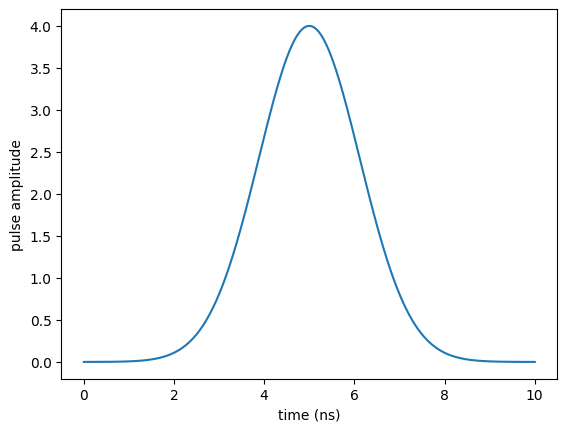

In [34]:
plot_pulse(eps0, tlist)

The complete Hamiltonian is instantiated as


In [35]:
def transmon_hamiltonian(Ec=0.386, EjEc=45, nstates=8, ng=0.0, T=10.0):
    """Transmon Hamiltonian

    Args:
        Ec: capacitive energy
        EjEc: ratio `Ej` / `Ec`
        nstates: defines the maximum and minimum states for the basis. The
            truncated basis will have a total of ``2*nstates + 1`` states

        ng: offset charge
        T: gate duration
    """

    Ej = EjEc * Ec
    n = np.arange(-nstates, nstates + 1)
    up = np.diag(np.ones(2 * nstates), k=-1)
    do = up.T
    H0 = qutip.Qobj(np.diag(4 * Ec * (n - ng) ** 2) - Ej * (up + do) / 2.0)
    H1 = qutip.Qobj(-2 * np.diag(n))

    return [H0, [H1, eps0]]

In [36]:
H = transmon_hamiltonian()

We define the logical basis $\ket{0_l}$ and $\ket{1_l}$ (not to be confused with
the charge states $\ket{n=0}$ and $\ket{n=1}$) as the eigenstates of the drift
Hamiltonian $\op{H}_0$ with the lowest energy. The optimization goal is to find a
potential $V_{opt}(t)$ such that after a given final time $T$ implements an
X-gate on this logical basis.


In [37]:
def logical_basis(H):
    H0 = H[0]
    eigenvals, eigenvecs = scipy.linalg.eig(H0.full())
    ndx = np.argsort(eigenvals.real)
    E = eigenvals[ndx].real
    V = eigenvecs[:, ndx]
    psi0 = qutip.Qobj(V[:, 0])
    psi1 = qutip.Qobj(V[:, 1])
    w01 = E[1] - E[0]  # Transition energy between states
    print("Energy of qubit transition is %.3f" % w01)
    return psi0, psi1

psi0, psi1 = logical_basis(H)

Energy of qubit transition is 6.914


We also introduce the projectors $P_i = \ket{\psi _i}\bra{\psi _i}$ for the logical
states $\ket{\psi _i} \in \{\ket{0_l}, \ket{1_l}\}$

In [38]:
proj0 = qutip.ket2dm(psi0)
proj1 = qutip.ket2dm(psi1)

## Optimization target

The key insight for the realization of a quantum gate $\Op{O}$ is that
(by virtue of linearity)

$$\ket{\Psi(t=0)} \rightarrow \ket{\Psi(t=T)}
    = \Op{U}(T, \epsilon(t))\ket{\Psi(0)}
    = \Op{O} \ket{\Psi(0)}
$$

is fulfilled for an arbitrary state $\Ket{\Psi(t=0)}$ if an only if
$\Op{U}(T, \epsilon(t))\ket{k} = \Op{O} \ket{k}$ for every state $\ket{k}$ in
logical basis, for the time evolution operator $\Op{U}(T, \epsilon(t))$ from
$t=0$ to $t=T$ under the same control $\epsilon(t)$.

The function `krotov.gate_objectives` automatically sets up the corresponding
objectives $\forall \ket{k}: \ket{k} \rightarrow \Op{O} \ket{k}$:


In [39]:
objectives = krotov.gate_objectives(
    basis_states=[psi0, psi1], gate=qutip.operators.sigmax(), H=H
)

objectives

[Objective[|Ψ₄(17)⟩ to |Ψ₅(17)⟩ via [H₄[17,17], [H₅[17,17], u₃(t)]]],
 Objective[|Ψ₅(17)⟩ to |Ψ₄(17)⟩ via [H₄[17,17], [H₅[17,17], u₃(t)]]]]

## Dynamics of the guess pulse


In [40]:
guess_dynamics = [
    objectives[x].mesolve(tlist, e_ops=[proj0, proj1]) for x in [0, 1]
]

In [41]:
def plot_population(result):
    '''Representation of the expected values for the initial states'''
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

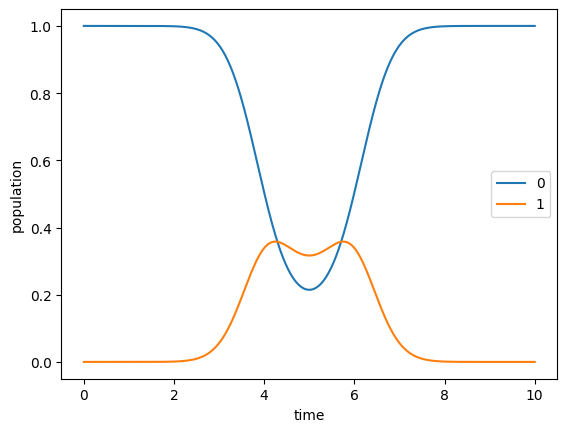

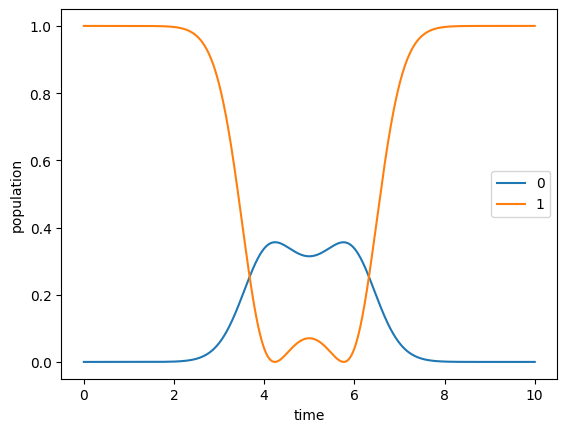

In [42]:
plot_population(guess_dynamics[0])
plot_population(guess_dynamics[1])

## Optimization

We define the desired shape of the update and the factor $\lambda_a$, and then start the optimization

In [43]:
def S(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(
        t, t_start=0.0, t_stop=10.0, t_rise=0.5, func='sinsq'
    )

pulse_options = {H[1][1]: dict(lambda_a=1, update_shape=S)}


In [44]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options,
    tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.print_table(
        J_T=krotov.functionals.J_T_re,
        show_g_a_int_per_pulse=True,
        unicode=False,
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below(1e-3, name='J_T'),
        krotov.convergence.delta_below(1e-5),
        krotov.convergence.check_monotonic_error,
    ),
    iter_stop=5,
)

iter.      J_T    g_a_int          J  Delta J_T    Delta J  secs
0     1.00e+00   0.00e+00   1.00e+00        n/a        n/a     2
1     2.80e-01   3.61e-01   6.41e-01  -7.20e-01  -3.59e-01     6
2     2.12e-01   3.42e-02   2.46e-01  -6.81e-02  -3.39e-02     6
3     1.35e-01   3.88e-02   1.74e-01  -7.72e-02  -3.83e-02     6
4     9.79e-02   1.87e-02   1.17e-01  -3.71e-02  -1.84e-02     6
5     7.13e-02   1.34e-02   8.47e-02  -2.65e-02  -1.32e-02     5


(this takes a while ...)

In [45]:
dumpfile = "./transmonxgate_opt_result.dump"
if os.path.isfile(dumpfile):
    opt_result = krotov.result.Result.load(dumpfile, objectives)
else:
    opt_result = krotov.optimize_pulses(
        objectives,
        pulse_options,
        tlist,
        propagator=krotov.propagators.expm,
        chi_constructor=krotov.functionals.chis_re,
        info_hook=krotov.info_hooks.print_table(
            J_T=krotov.functionals.J_T_re,
            show_g_a_int_per_pulse=True,
            unicode=False,
        ),
        check_convergence=krotov.convergence.Or(
            krotov.convergence.value_below(1e-3, name='J_T'),
            krotov.convergence.delta_below(1e-5),
            krotov.convergence.check_monotonic_error,
        ),
        iter_stop=1000,
        continue_from=opt_result
    )
    opt_result.dump(dumpfile)

iter.      J_T    g_a_int          J  Delta J_T    Delta J  secs
0     7.13e-02   0.00e+00   7.13e-02        n/a        n/a     3
6     5.55e-02   7.96e-03   6.34e-02  -1.58e-02  -7.87e-03     6
7     4.66e-02   4.46e-03   5.11e-02  -8.87e-03  -4.42e-03     6
8     4.20e-02   2.32e-03   4.43e-02  -4.62e-03  -2.30e-03     5
9     3.95e-02   1.23e-03   4.08e-02  -2.45e-03  -1.23e-03     6
10    3.81e-02   7.45e-04   3.88e-02  -1.49e-03  -7.45e-04     6
11    3.70e-02   5.39e-04   3.75e-02  -1.08e-03  -5.39e-04     6
12    3.61e-02   4.45e-04   3.65e-02  -8.90e-04  -4.45e-04     6
13    3.53e-02   3.97e-04   3.57e-02  -7.93e-04  -3.96e-04     6
14    3.46e-02   3.66e-04   3.49e-02  -7.31e-04  -3.65e-04     5
15    3.39e-02   3.42e-04   3.42e-02  -6.81e-04  -3.40e-04     5
16    3.32e-02   3.20e-04   3.36e-02  -6.37e-04  -3.17e-04     6
17    3.26e-02   2.99e-04   3.29e-02  -5.95e-04  -2.96e-04     6
18    3.21e-02   2.79e-04   3.24e-02  -5.55e-04  -2.76e-04     6
19    3.16e-02   2.60e-04

In [46]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2024-06-13 13:51:17
- Number of objectives: 2
- Number of iterations: 398
- Reason for termination: Reached convergence: Δ(('info_vals', T[-1]),('info_vals', T[-2])) < 1e-05
- Ended at 2024-06-13 14:31:07 (0:39:50)

In [47]:
def plot_convergence(result):
    fig, ax = plt.subplots()
    ax.semilogy(result.iters, np.array(result.info_vals))
    ax.set_xlabel('OCT iteration')
    ax.set_ylabel('error')
    plt.show(fig)

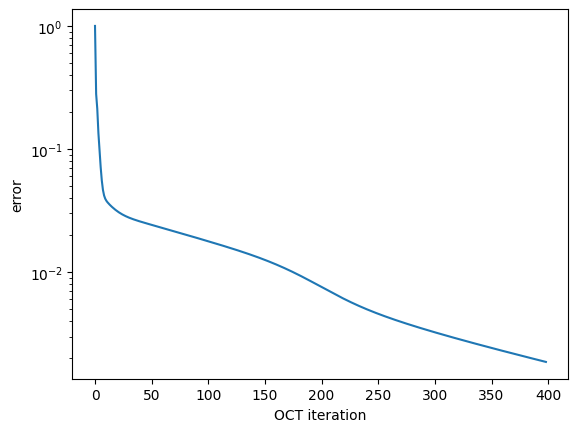

In [48]:
plot_convergence(opt_result)

## Optimized pulse and dynamics

We obtain the following optimized pulse:

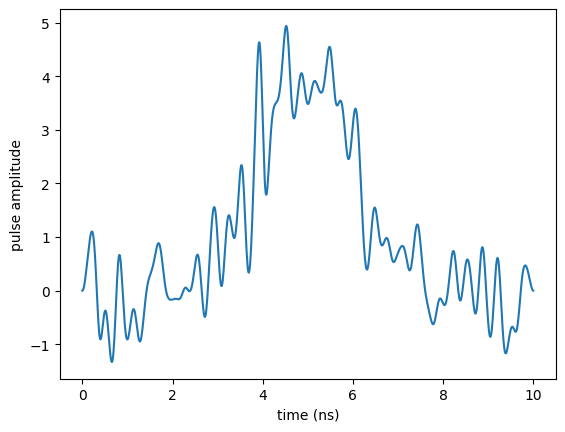

In [49]:
plot_pulse(opt_result.optimized_controls[0], tlist)

The oscillations in the control shape indicate non-negligible spectral broadening:

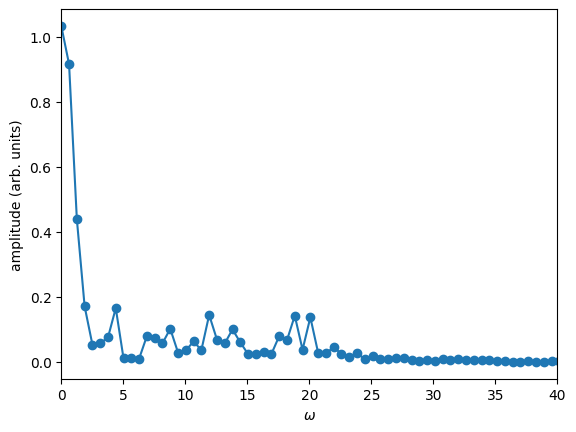

In [50]:
def plot_spectrum(pulse, tlist, xlim=None):

    if callable(pulse):
        pulse = np.array([pulse(t, None) for t in tlist])

    dt = tlist[1] - tlist[0]
    n = len(tlist)

    w = np.fft.fftfreq(n, d=dt/(2.0*np.pi))
    # the factor 2π in the normalization means that
    # the spectrum is in units of angular frequency,
    # which is normally what we want

    spectrum = np.fft.fft(pulse) / n
    # normalizing the spectrum with n means that
    # the y-axis is independent of dt

    # we assume a real-valued pulse, so we throw away
    # the half of the spectrum with negative frequencies
    w = w[range(int(n / 2))]
    spectrum = np.abs(spectrum[range(int(n / 2))])

    fig, ax = plt.subplots()
    ax.plot(w, spectrum, '-o')
    ax.set_xlabel(r'$\omega$')
    ax.set_ylabel('amplitude (arb. units)')
    if xlim is not None:
        ax.set_xlim(*xlim)
    plt.show(fig)


plot_spectrum(opt_result.optimized_controls[0], tlist, xlim=(0, 40))

Lastly, we verify that the pulse produces the desired dynamics $\ket{0_l} \rightarrow \ket{1_l}$ and $\ket{1_l} \rightarrow \ket{0_l}$:

In [51]:
opt_dynamics = [
    opt_result.optimized_objectives[x].mesolve(tlist, e_ops=[proj0, proj1])
    for x in [0, 1]
]

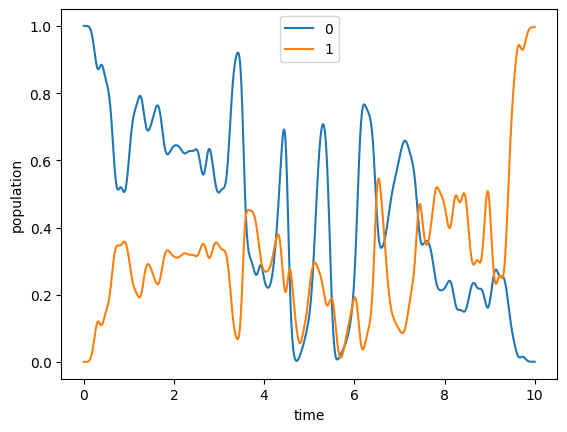

In [52]:
plot_population(opt_dynamics[0])

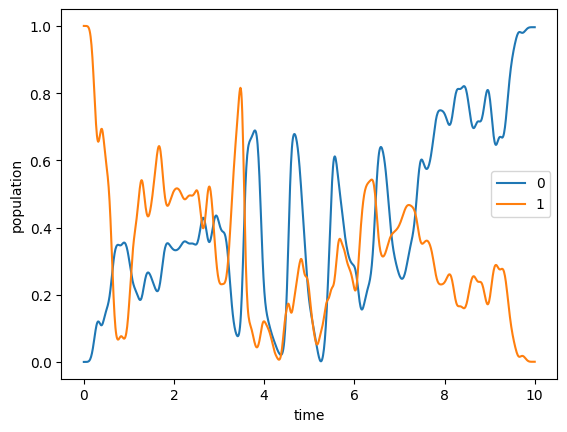

In [53]:
plot_population(opt_dynamics[1])

Since the optimized pulse shows some oscillations (cf. the spectrum above),
it is a good idea to check for any discretization error. To this end, we also
propagate the optimization result using the same propagator that
was used in the optimization (instead of `qutip.mesolve`). The main difference
between the two propagations is that `mesolve` assumes piecewise constant
pulses that switch between two points in `tlist`, whereas `propagate` assumes
that pulses are constant on the intervals of `tlist`, and thus switches *on*
the points in `tlist`.

In [54]:
opt_dynamics2 = [
    opt_result.optimized_objectives[x].propagate(
        tlist, e_ops=[proj0, proj1], propagator=krotov.propagators.expm
    )
    for x in [0, 1]
]

The difference between the two propagations gives an indication of the error
due to the choice of the piecewise constant time discretization. If this error
were unacceptably large, we would need a smaller time step.

In [55]:
# NBVAL_IGNORE_OUTPUT
# Note: the particular error value may depend on the version of QuTiP
print(
    "Time discretization error = %.1e" %
    abs(opt_dynamics2[0].expect[1][-1] - opt_dynamics[0].expect[1][-1])
)

Time discretization error = 2.0e-05
